In [8]:
import numpy as np
np.random.seed(12)
import matplotlib.pyplot as plt
import astropy.units as u
import astropy.constants as const
import os
from scipy.optimize import curve_fit
import pandas as pd

%matplotlib inline

In [9]:
DATA_DIR = '../data/scan_data/'
DATA_FILE = '20260129_135554.csv'
data = pd.read_csv(os.path.join(DATA_DIR, DATA_FILE))
data = data.drop(index=0)
data

,timestamp,position_mm,x,y,r,theta
1,1.769717e+09,0.251465,0.000256,5.447732e-05,0.000262,12.000035
2,1.769717e+09,0.540039,0.000279,4.445269e-05,0.000283,9.041710
3,1.769717e+09,0.843262,0.000135,6.703833e-06,0.000135,2.840848
4,1.769717e+09,1.166260,0.000163,-9.895232e-06,0.000163,-3.478709
5,1.769717e+09,1.454346,0.000081,-1.785603e-05,0.000083,-12.401043
...,...,...,...,...,...,...
650,1.769717e+09,197.619629,0.000129,-3.891721e-05,0.000134,-16.826508
651,1.769717e+09,197.930176,0.000059,8.976781e-07,0.000059,0.876154
652,1.769717e+09,198.237793,0.000154,-1.437304e-05,0.000155,-5.319963
653,1.769717e+09,198.540527,0.000127,8.476874e-06,0.000127,3.813035


In [10]:
TIMESTAMPS = data['timestamp'].values * u.s
POS = data['position_mm'].values * u.mm
R = data['r'].values * u.V  # Assuming lock-in outputs in V
X = data['x'].values * u.V
Y = data['y'].values * u.V
THETA = data['theta'].values * u.deg

print(f"Total samples: {len(POS)}")
print(f"Position range: {POS.min():.2f} to {POS.max():.2f}")
print(f"Scan duration: {(TIMESTAMPS[-1] - TIMESTAMPS[0]):.2f}")

Total samples: 654
Position range: 0.25 mm to 198.83 mm
Scan duration: 66.22 s


In [11]:
OPD = POS * 2
I = (R - np.mean(R)).to(u.mV)

In [12]:
OPD_INTERP = np.linspace(OPD.min(), OPD.max(), OPD.size)
I_INTERP = np.interp(OPD_INTERP, OPD, I)

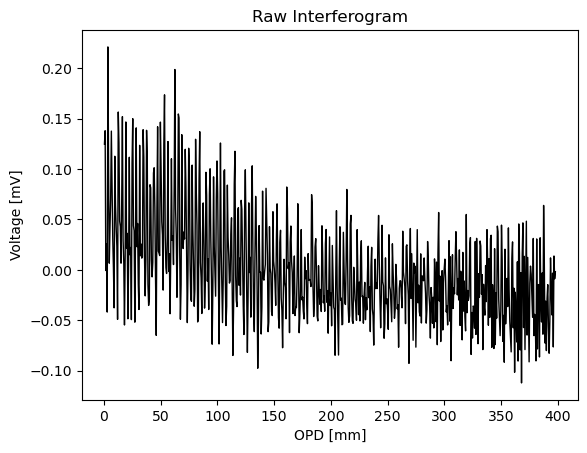

In [14]:
plt.plot(OPD_INTERP, I_INTERP, 'k', lw=1)
plt.title('Raw Interferogram')
plt.ylabel(f'Voltage [{I.unit}]')
plt.xlabel(f'OPD [{OPD.unit}]')
plt.show()

In [18]:
SPECTRUM = np.fft.rfft(I_INTERP)
POWER = np.abs(SPECTRUM)**2

WAVENUMBERS = np.fft.rfftfreq(OPD_INTERP.size, np.diff(OPD_INTERP).mean()).to(1/u.cm)
FREQS = WAVENUMBERS.to(u.GHz, equivalencies=u.spectral())

nyq_freq = (const.c / (2 * np.diff(OPD_INTERP).mean())).to(u.GHz)
print(f"Nyquist frequency: {nyq_freq:.1f}")

Nyquist frequency: 246.5 GHz


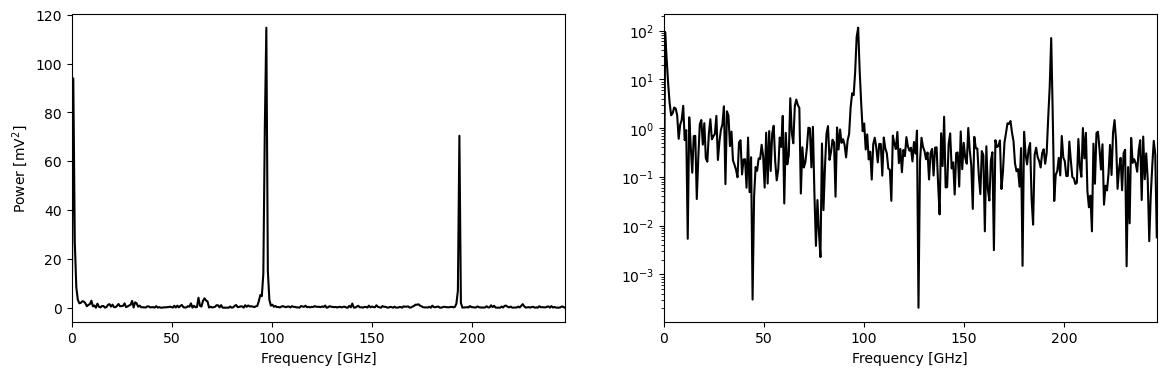

In [21]:
POWER_UNIT = r'$\mathrm{mV^2}$'

%matplotlib inline
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].plot(FREQS, POWER, color='k', lw=1.5)
axes[0].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[0].set_ylabel(rf'Power [{POWER_UNIT}]')
axes[0].set_xlim(0, FREQS.value.max())

axes[1].semilogy(FREQS, POWER, color='k', lw=1.5)
axes[1].set_xlabel(rf'Frequency [{FREQS.unit}]')
axes[1].set_xlim(0, FREQS.value.max())
plt.show()
